In this example we will show using an implementation of the `NearestNeighborsIndex` interface to index computed descriptor vectors and then querying that index later to retrieve k nearest neighbors.

This example will require an additional depedency of PyTorch for descriptor computation later.
Additionally, we will utilize in interface plugin implementation that uses the FAISS package.
We will use matplotlib later to render result images.

In [1]:
!pip install \
    torch==1.9.0 \
    torchvision==0.10.0 \
    faiss_cpu==1.7.0 \
    matplotlib==3.3.4

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

# Get some Image Data
First we need to acquire some image data to describe and index.
For this example we will acquire the public Leeds Butterfly Dataset which is relatively small but not trivially so.
This file is about 454MB.

Dataset home-page: http://www.josiahwang.com/dataset/leedsbutterfly/

    Josiah Wang, Katja Markert, and Mark Everingham. "Learning Models for Object Recognition from Natural Language Descriptions". In Proceedings of the 20th British Machine Vision Conference (BMVC2009), September 2009.

In [2]:
from hashlib import sha1
from pathlib import Path

data_dir = Path("data")
images_dir = data_dir / "leedsbutterfly" / "images"

dataset_url = "http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip"
dataset_hash = "b94cc7630c2552191dfffa1668e99ede233a1e1a"
dataset_zip = data_dir / Path(dataset_url.split('/')[-1])

if not images_dir.is_dir():
    !mkdir -p {images_dir.parent.parent.as_posix()}
    !wget {dataset_url} -O {dataset_zip.as_posix()}
    assert sha1(dataset_zip.open(mode='rb').read()).hexdigest() == dataset_hash, \
        "Downloaded file did not match the expected SHA1 hash. Please check source."
    !unzip -u {dataset_zip.as_posix()} -d {data_dir}
    dataset_zip.unlink()
    
image_file_list = list(images_dir.iterdir())
print(f"{len(image_file_list)} butterfly images ready for use!")

832 butterfly images ready for use!


# Compute Descriptor Vectors
For this example we will use a PyTorch pretrained model to compute some descriptors for these images.
Image pre-processing for the model will follow the description [here](https://pytorch.org/hub/pytorch_vision_resnet/) from PyTorch.

In [3]:
import numpy as np
import PIL.Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder


use_cuda = torch.cuda.is_available()

# Cut off the final linear layer so we get at the pool2D layer
model = torch.nn.Sequential(*list(resnet50(pretrained=True).children())[:-1])
if use_cuda:
    model = model.cuda()
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Let's make a Dataset for use with this model
class ButterflyDataset (Dataset):
    def __len__(self):
        return len(image_file_list)
    def __getitem__(self, idx):
        return preprocess(PIL.Image.open(image_file_list[idx]))
    
butterfly_dataset = ButterflyDataset()

# Compute descriptor vectors -- 2048dim
descriptor_batch_output = []
dl = DataLoader(butterfly_dataset, batch_size=8, num_workers=4, pin_memory=use_cuda)
with torch.no_grad():
    for batch in dl:
        if use_cuda:
            batch = batch.cuda()
        feats = model(batch).squeeze()
        descriptor_batch_output.append(feats.cpu().numpy())
        
descriptor_output = np.vstack(descriptor_batch_output)

/home/local/KHQ/paul.tunison/.cache/pypoetry/virtualenvs/smqtk-indexing-2bwyfQPm-py3.6/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Construct Index
SMQTK-Indexing provides an interface, `NearestNeighborsIndex`, and a number of possible implementations to satisfy
that interface.
One implementation of which is the FAISS plugin, `FaissNearestNeighborsIndex`, which uses the FAISS package to satisfy the interface's abstract methods.

While implementations may be factory generated from dynamic plugin discover and a JSON configuration, for this example we will more simply directly import the `FaissNearestNeighborsIndex` implementation.

The `NearestNeighborsIndex` defines building and querying in terms of `DescriptorElement` objects.
This is an abstraction of descriptor vector storage and representation, normalizing access to that of `numpy.ndarray`.
These elements also have a UID slot to uniquely address each descriptor, which is a useful feature for more complex descriptor associations.
To keep things simple here, we will just translate each descriptor vector to a linear set of in-memory `DescriptorElement` instances, whose UIDs are simply the index of the descriptor, and thus imagery.

In [4]:
from smqtk_descriptors import DescriptorSet
from smqtk_descriptors.impls.descriptor_element.memory import DescriptorMemoryElement
from smqtk_indexing.impls.nn_index.faiss import FaissNearestNeighborsIndex

In [5]:
# Assocate descriptor vectors as DescriptorElement implementation instances.
# -- We will hold out vector idx 500 for querying later.
descriptor_element_list = [
    DescriptorMemoryElement(i).set_vector(d)
    for i, d in enumerate(descriptor_output)
    if i != 500
]

In [6]:
# Create the index
index = FaissNearestNeighborsIndex()

# Populate the index with a build.
index.build_index(descriptor_element_list)

assert len(index) == (len(image_file_list)-1)

# Querying The Index
Lastly we will show querying the index using an query.

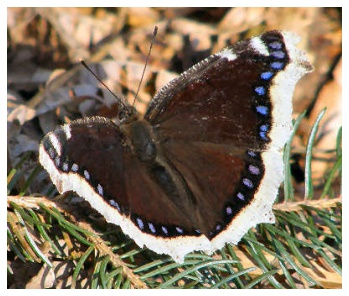

In [7]:
# Pick one of the images from the dataset.
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(image_file_list[500]))

In [8]:
n_elems, n_dists = index.nn(
    DescriptorMemoryElement("query").set_vector(descriptor_output[500]),
    n=6
)

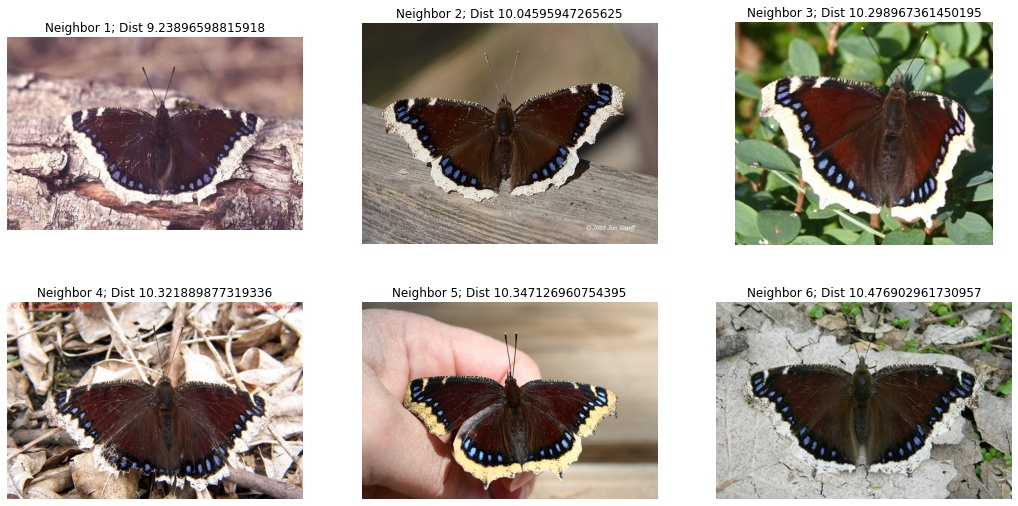

In [9]:
# Lets render the neighbors!
plt.figure(figsize=(18, 9))
shape = (2, 3)

for i, e in enumerate(n_elems):
    plt.subplot(*shape, i+1)
    plt.axis('off')
    plt.title(f"Neighbor {i+1}; Dist {n_dists[i]}")
    plt.imshow(PIL.Image.open(image_file_list[e.uuid()]))

[102 435 270 106  71 700]


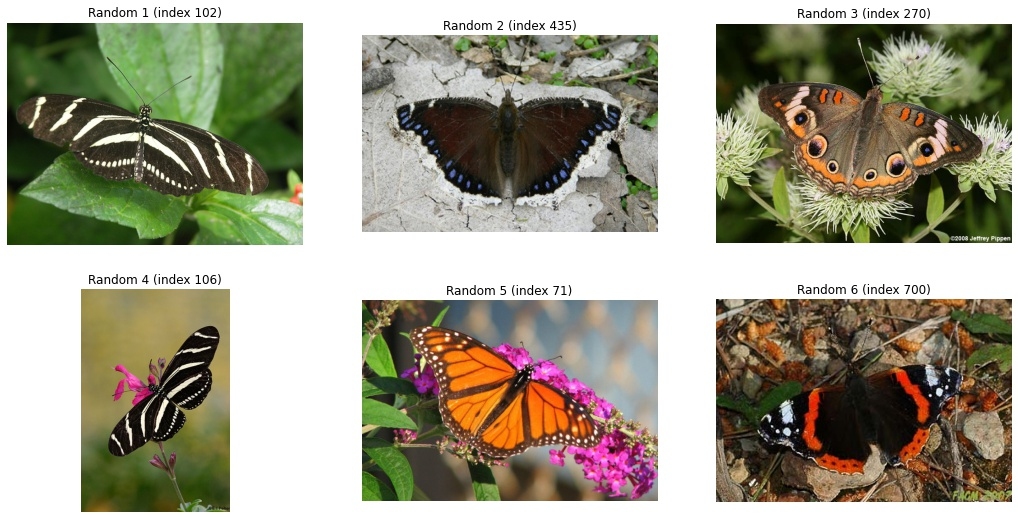

In [10]:
# The above certainly looks better than random retrieval
rs = np.random.RandomState(seed=42)
rand_idxs = rs.choice(np.arange(len(image_file_list)), 6)
print(rand_idxs)

plt.figure(figsize=(18, 9))
shape = (2, 3)

for i, e in enumerate(rand_idxs):
    plt.subplot(*shape, i+1)
    plt.axis('off')
    plt.title(f"Random {i+1} (index {e})")
    plt.imshow(PIL.Image.open(image_file_list[e]))